### Pinhole Camera model for NeRF
other camera models can also be used but the easiest and the most used one is the pinhole model.

In [73]:
import numpy as np
import matplotlib.pyplot as plt 
import torch

In [77]:
c2w1 = np.array([0.34303784370422363,
                 -0.8594792485237122,
                 0.3789729177951813,
                 3.7897279262542725,
                 0.9393215775489807,
                 0.3138796091079712,
                 -0.13839992880821228,
                 -1.3840025663375854,
                 0.0,
                 0.40345385670661926,
                 0.9150000214576721,
                 9.149999618530273,
                 0.0,
                 0.0,
                 0.0,
                 1.0])
c2w1 = c2w1.reshape((4, 4))


c2w2 = np.array([-0.7053813934326172,
                -0.5776947736740112,
                0.41073814034461975,
                4.1073899269104,
                0.7088279724121094,
                -0.5748858451843262,
                0.4087409973144531,
                4.087401390075684,
                0.0,
                0.5794609785079956,
                0.8149999976158142,
                8.149999618530273,
                0.0,
                0.0,
                0.0,
                1.0])
c2w2 = c2w2.reshape((4, 4))

identity = np.identity(4)

In [78]:
c2w1, c2w1.shape

(array([[ 0.34303784, -0.85947925,  0.37897292,  3.78972793],
        [ 0.93932158,  0.31387961, -0.13839993, -1.38400257],
        [ 0.        ,  0.40345386,  0.91500002,  9.14999962],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 (4, 4))

In [79]:
H = 400
W = 400
f = 1200

camera2world [4x4]

for rotation
camera2world [3x3]
dirs [nb_rays, 3]

camera2world @ (nb_rays,3, 1) therefore need to add extra 1 dim at the end of dirs

In [102]:
camera2world = c2w2

In [103]:
rays_origin = np.zeros((H*W, 3))
rays_direction = np.zeros((H*W, 3))

u = np.arange(W)
v = np.arange(H)
u, v = np.meshgrid(u, v)

dirs = np.stack((u - W / 2,
                 -(v - H / 2),
                 - np.ones_like(u) * f), axis=-1)

dirs = (camera2world[:3, :3] @ dirs[..., None]).squeeze(-1)

rays_direction = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)
rays_direction = rays_direction.reshape(-1, 3)

rays_origin += camera2world[:3, 3]

In [104]:
dirs.shape

(400, 400, 3)

In [105]:
def plot_rays(o, d, t):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')
    
    pt1 = o
    pt2 = o + t * d
    
    for p1, p2 in zip(pt1[::50], pt2[::50]): #plot 1/50
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]])
    
    
    plt.xlabel('$X$ - coord')
    plt.ylabel('$Y$ - coord')
    
    plt.show()

rays_direction.reshape(-1, 3).shape, rays_direction.shape

((160000, 3), (160000, 3))

In [106]:
#in this convention
rays_direction = rays_direction.reshape(-1, 3)
rays_direction.shape, rays_origin.shape

((160000, 3), (160000, 3))

## identity

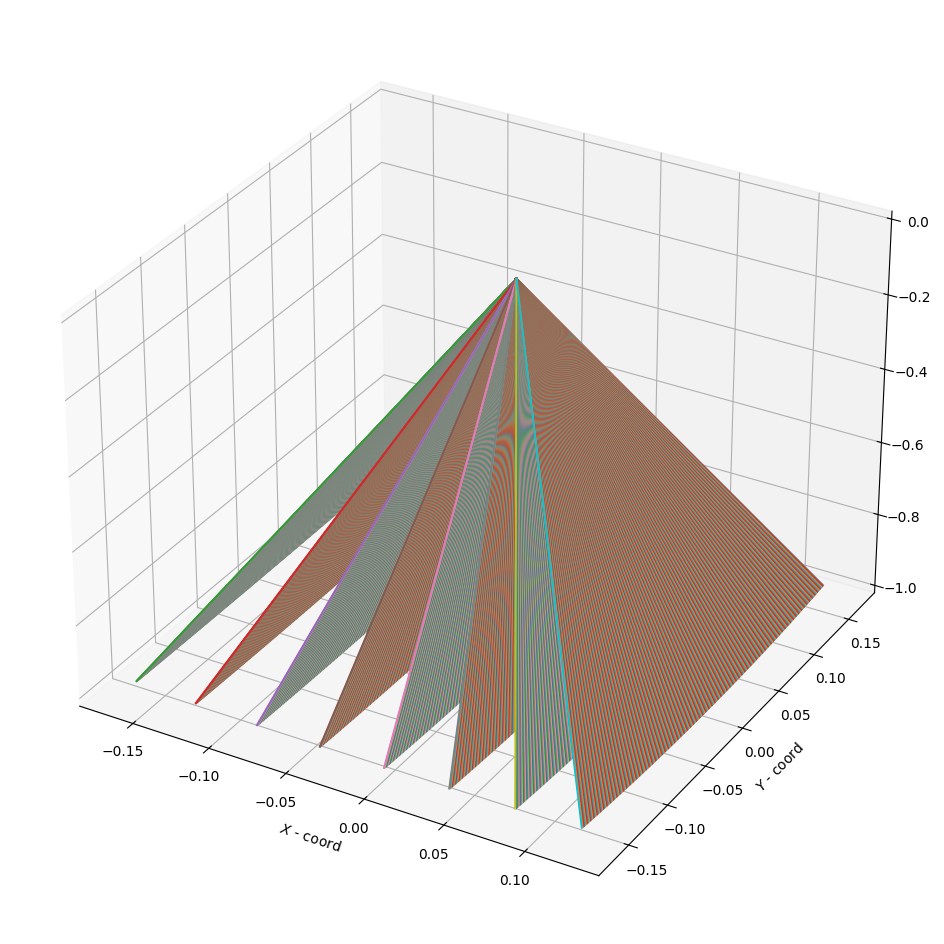

In [85]:
plot_rays(rays_origin, rays_direction, 1)

## c2w1

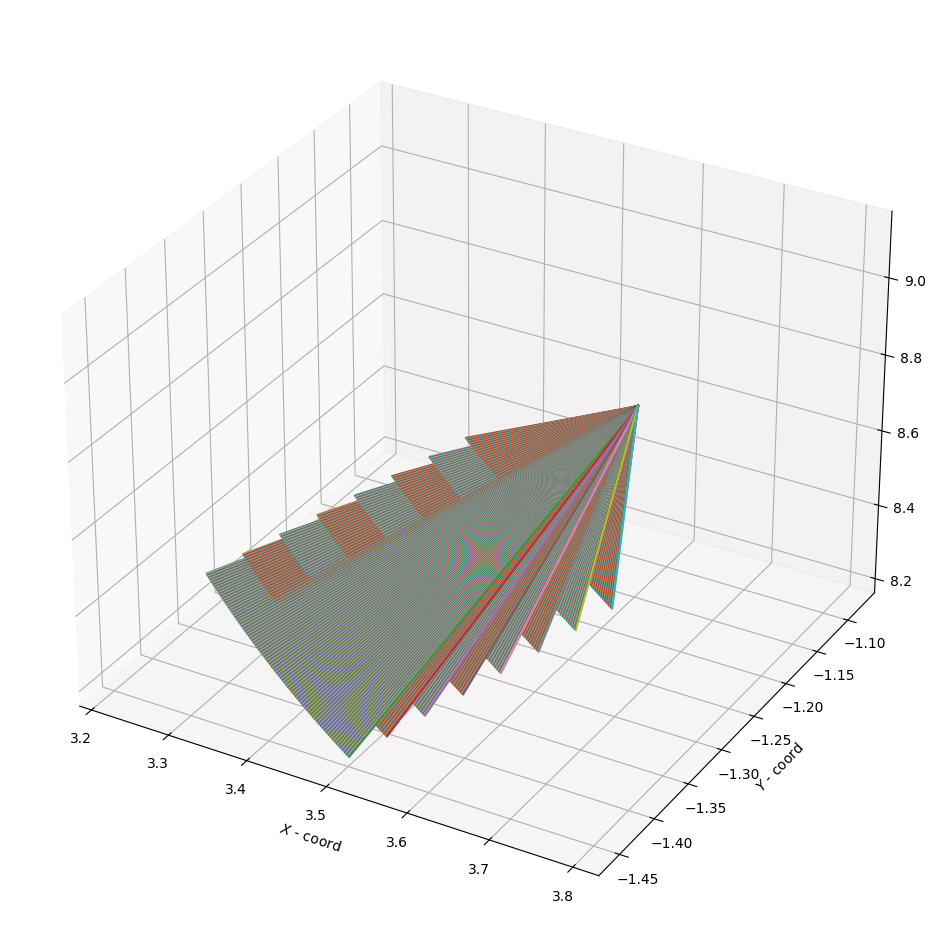

In [96]:
plot_rays(rays_origin, rays_direction, 1)

## c2w2

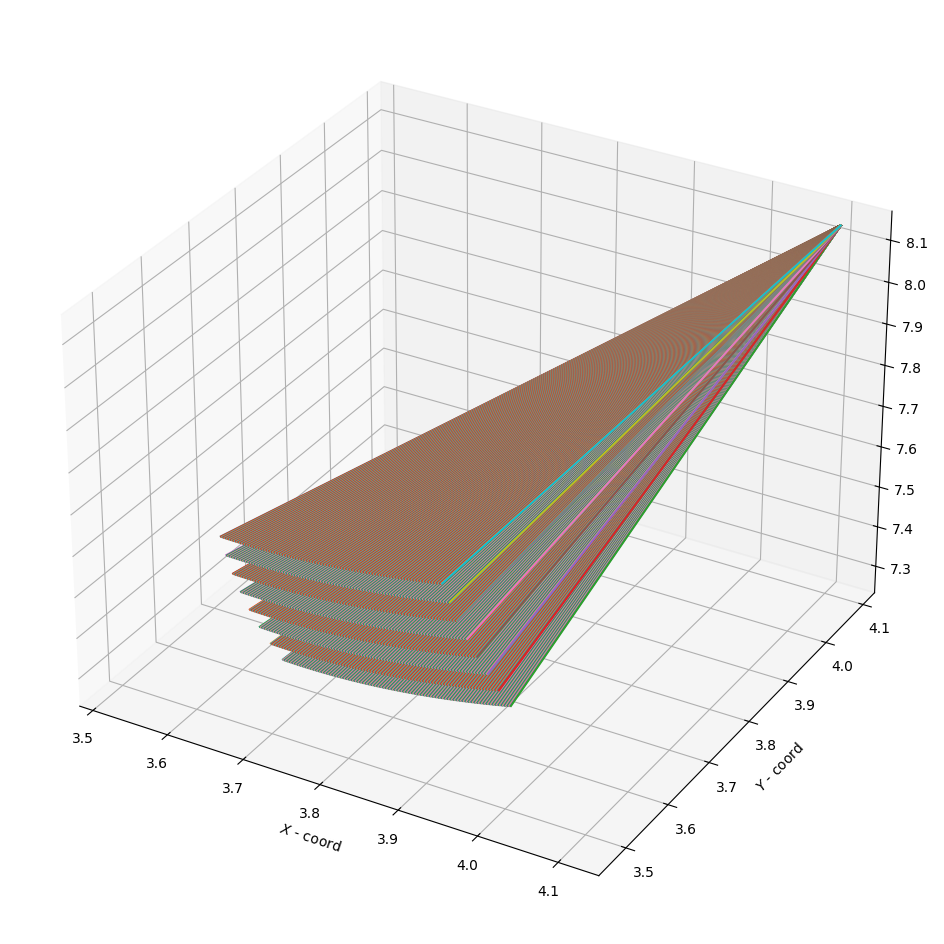

In [107]:
plot_rays(rays_origin, rays_direction, 1)

## Ray tracing and assign colors to the rays to create an image

In [108]:
class Sphere():
    def __init__(self, position, radius, color):
        self.position = position
        self.radius = radius
        self.color = color
        
    def intersect(self, x): #tells if ray hits the sphere or not
        """_summary_

        Args:
            x (parameter): points shape [batch_size, 3]

        Returns:
            _type_: _description_
        """
        # check if inside the sphere
        # (x-xo)^2 + (y-yo)^2 + (z-zo)^2 < r^2
        condition =(x[:, 0] - self.position[0])**2 + (x[:, 1] - self.position[1])**2 + (x[:, 2] - self.position[2])**2 <= self.radius**2
        
        number_of_rays = x.shape[0]
        colors = torch.zeros((number_of_rays, 3))
        density = torch.zeros((number_of_rays, 1))

        colors[condition] = self.color #assign color where condition passes
        density[condition] = 10 # assume constant
        
        #creating a partition on the sphere for visuals
        color_condition = x[:, 0] < 0
        temp = colors[color_condition, 0].clone()
        colors[color_condition, 0] = colors[color_condition, 1].clone()
        colors[color_condition, 1] = temp
        
        return colors, density

In [109]:
def compute_accumulated_transmittance(betas):
    accumulated_transmittance = torch.cumprod(betas, 1)
    accumulated_transmittance[:, 1:] = accumulated_transmittance[:, :-1] #since we shift to the right
    #sum goes from i =1 to i= N-1
    accumulated_transmittance[:, 0] = 1.  # as T0 should be 1
    #will improve to better differeniability later!
    return accumulated_transmittance

In [110]:
def rendering(model, rays_origin, rays_direction, tn, tf, nb_bins = 100, device = 'cpu'):
    # device = 'cuda' if torch.cuda.is_available() else 'cpu'
    t = torch.linspace(tn, tf, nb_bins).to(device) #making the bins #size is no of bins

    delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10]))) #size is no of bins - 1 so we concat infinity as the last value
    #most nerf papers take the last delta value as infinity
    
    #convert to torch.Tensors
    rays_origin = torch.from_numpy(rays_origin)
    rays_direction = torch.from_numpy(rays_direction)
    # x = rays_origin + t * rays_direction
    # t.shape = [nb_bins]
    # rays_origin.shape and rays_direction = [nb_rays, nb_bins, 3]
    
    #broadcasting does not work in here therfore reshape the vectors
    
    # t.shape = [1, nb_bins, 1]
    # rays_origin.shape and rays_direction = [nb_rays, 1, 3]
    
    x = rays_origin.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * rays_direction.unsqueeze(1)
    # query the opacity and the colors at each point x
    #query the color and the denisty at each point X to
    # comput the integral
    
    colors, density = model.intersect(x.reshape(-1, 3))
    
    #reshape colors to [nb_rays, nb_bins, 3]
    #reshape density to [nb_rays, nb_bins, 1]
    colors = colors.reshape((x.shape[0], nb_bins, 3)) #shape [nb_rays, nb_bins, 3]
    density = density.reshape((x.shape[0], nb_bins, 1))
    
    alpha = 1 - torch.exp(-density.squeeze() * delta.unsqueeze(0)) # shape [nb_rays, nb_bins, 1]
    T = compute_accumulated_transmittance(1 - alpha) # shape [nb_rays, nb_bins, 1]
    color = (T.unsqueeze(-1) * alpha.unsqueeze(-1) * colors).sum(1) #shape [nb_rays, 3]
    return color

In [111]:
trial_origin = torch.Tensor([0., 0., 0.])
trial_color = torch.Tensor([1., 0., 1.])
trial_radius = torch.Tensor([1])

s = Sphere(trial_origin, trial_radius,trial_color)
px_colors = rendering(s, rays_origin,rays_direction, 8, 12)

## identity

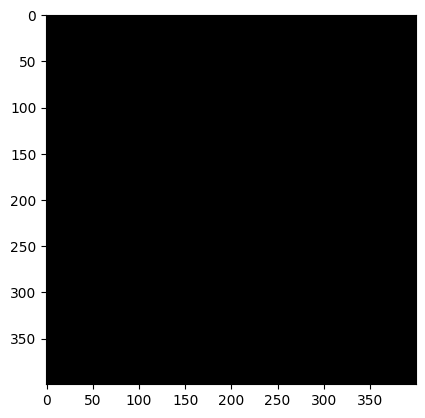

In [90]:
#c2w1
img = px_colors.reshape(H,W, 3).cpu().numpy()
plt.figure(dpi=100)
plt.imshow(img)

## c2w1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


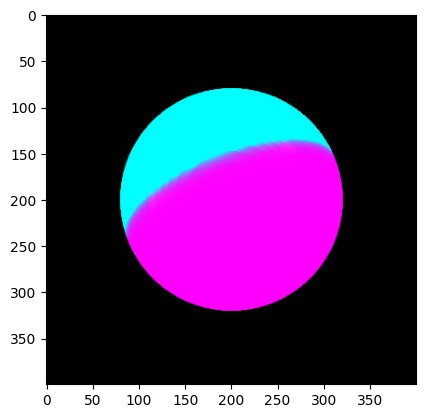

In [101]:
#c2w1
img = px_colors.reshape(H,W, 3).cpu().numpy()
plt.figure(dpi=100)
plt.imshow(img)

## c2w2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


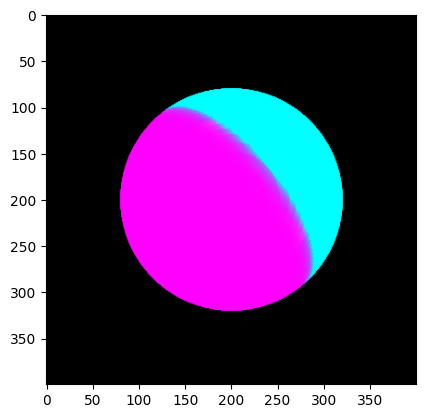

In [112]:
#c2w1
img = px_colors.reshape(H,W, 3).cpu().numpy()
plt.figure(dpi=100)
plt.imshow(img)